<a href="https://colab.research.google.com/github/Eieiz007/Data-science-project-in-university/blob/main/GRU_Many_to_Many.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [19]:
import numpy as np
import tensorflow as tf
import pandas as pd

import tensorflow as tf

from tensorflow.keras.optimizers import Adam , AdamW
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , GRU , SimpleRNN , BatchNormalization
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler , MinMaxScaler

# Create data

In [2]:
num_days = 700
dates = pd.date_range(start="2020-01-01", periods=num_days, freq="D")
oil_prices = 50 + 5 * np.sin(np.linspace(0, 20, num_days)) + np.random.normal(0, 1, num_days)
temperature = 30 + 10 * np.sin(np.linspace(0, 10, num_days)) + np.random.normal(0, 1, num_days)

df = pd.DataFrame({"Date": dates, "Oil_Price": oil_prices, "Temperature": temperature})

df.head()

,Date,Oil_Price,Temperature
0,2020-01-01,50.624577,30.756565
1,2020-01-02,50.517657,30.306495
2,2020-01-03,49.713281,31.087833
3,2020-01-04,49.496190,30.286568
4,2020-01-05,50.328691,30.114024


# prepartation data

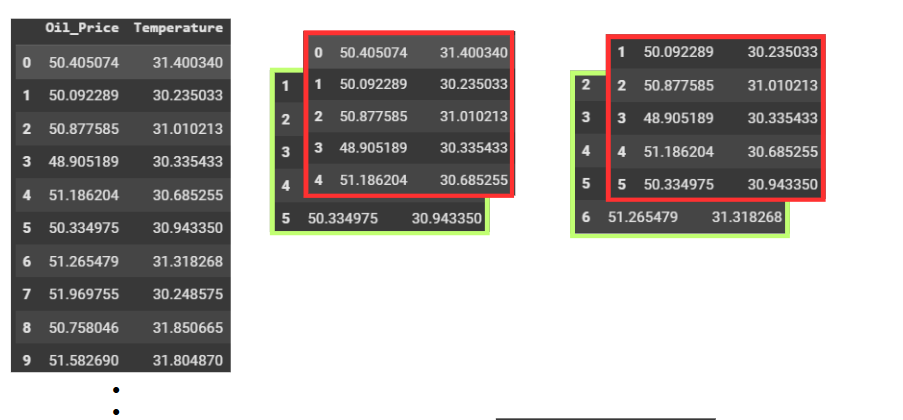

In [3]:
time_step = 5 #ใช้ข้อมูลก่อนหน้า 5 ทำนาย

In [4]:
df.head()

,Date,Oil_Price,Temperature
0,2020-01-01,50.624577,30.756565
1,2020-01-02,50.517657,30.306495
2,2020-01-03,49.713281,31.087833
3,2020-01-04,49.496190,30.286568
4,2020-01-05,50.328691,30.114024


In [5]:
X, y = [], []

for i in range(len(df) - time_step):
    X.append(df.iloc[i:i+time_step, 1:].values)
    # iloc[0:1+5] = [0 1 2 3 4]
    y.append(df.iloc[i+1:i+time_step+1, 1:].values)
    # iloc[0+5] = [1 2 3 4 5]


In [6]:
X[:2]

[array([[50.62457654, 30.75656485],
        [50.51765688, 30.30649506],
        [49.7132807 , 31.08783323],
        [49.49618983, 30.28656849],
        [50.32869147, 30.11402354]]),
 array([[50.51765688, 30.30649506],
        [49.7132807 , 31.08783323],
        [49.49618983, 30.28656849],
        [50.32869147, 30.11402354],
        [52.569483  , 31.78944547]])]

In [7]:
y[:2]

[array([[50.51765688, 30.30649506],
        [49.7132807 , 31.08783323],
        [49.49618983, 30.28656849],
        [50.32869147, 30.11402354],
        [52.569483  , 31.78944547]]),
 array([[49.7132807 , 31.08783323],
        [49.49618983, 30.28656849],
        [50.32869147, 30.11402354],
        [52.569483  , 31.78944547],
        [48.72056411, 32.27772425]])]

In [8]:
# แปลงเป็น numpy array
X = np.array(X)
y = np.array(y)

# ตรวจสอบ shape
X.shape, y.shape

((695, 5, 2), (695, 5, 2))

# splitting data

In [9]:
# แบ่งข้อมูล Train (70%) และ (Val+Test) (30%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, shuffle=False) #ห้ามสุ่มเพราะเป็น time series
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

In [10]:
X_train.reshape(-1, X_train.shape[-1]) #ลดให้เหลือ 2D เพราะ standardization must 2d

array([[50.62457654, 30.75656485],
       [50.51765688, 30.30649506],
       [49.7132807 , 31.08783323],
       ...,
       [46.50021637, 27.61441534],
       [47.11815759, 26.7378184 ],
       [46.43049237, 27.99142818]])

In [11]:
#แปลงกลับ
X_train.reshape(-1, X_train.shape[-1]).reshape(X_train.shape)[:2] # == x_train แปลงกลับมา 3D เหมือนเดิม

array([[[50.62457654, 30.75656485],
        [50.51765688, 30.30649506],
        [49.7132807 , 31.08783323],
        [49.49618983, 30.28656849],
        [50.32869147, 30.11402354]],

       [[50.51765688, 30.30649506],
        [49.7132807 , 31.08783323],
        [49.49618983, 30.28656849],
        [50.32869147, 30.11402354],
        [52.569483  , 31.78944547]]])

In [12]:

# สร้างตัวแปร StandardScaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit transform กับ Training data และ Transform ชุดอื่น ๆ
X_train_scaled = scaler_X.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_val_scaled = scaler_X.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
X_test_scaled = scaler_X.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, y_train.shape[-1])).reshape(y_train.shape)
y_val_scaled = scaler_y.transform(y_val.reshape(-1, y_val.shape[-1])).reshape(y_val.shape)
y_test_scaled = scaler_y.transform(y_test.reshape(-1, y_test.shape[-1])).reshape(y_test.shape)

# ตรวจสอบ shape
print("Train shape:", X_train_scaled.shape, y_train_scaled.shape)
print("Validation shape:", X_val_scaled.shape, y_val_scaled.shape)
print("Test shape:", X_test_scaled.shape, y_test_scaled.shape)


Train shape: (417, 5, 2) (417, 5, 2)
Validation shape: (139, 5, 2) (139, 5, 2)
Test shape: (139, 5, 2) (139, 5, 2)


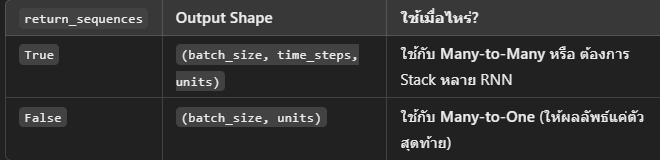

In [13]:
X_train_scaled.shape

(417, 5, 2)

# Model

In [29]:
"""
Many to one  = return_sequences=True
input_shape = (time_steps, features)

"""

# สร้างโมเดล LSTM (Many-to-One)
model = Sequential([
    GRU(256, activation='gelu', return_sequences=True, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])),
    Dense(256, activation='gelu'), #FC
    BatchNormalization(),
    Dense(128, activation='gelu'), #FC
    Dense(2)  # Output 2 ค่า (Oil_Price, Temperature)
])

# คอมไพล์โมเดล
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')

# Train โมเดล
history = model.fit(X_train_scaled, y_train_scaled,
                    validation_data=(X_val_scaled, y_val_scaled),
                    epochs=50, batch_size=64, verbose=1)

Epoch 1/50


Exception ignored in: <function _xla_gc_callback at 0x7b791a193ce0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/jax/_src/lib/__init__.py", line 96, in _xla_gc_callback
    def _xla_gc_callback(*args):
    
KeyboardInterrupt: 


7/7 ━━━━━━━━━━━━━━━━━━━━ 39s 202ms/step - loss: 0.3378 - val_loss: 0.4959
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 170ms/step - loss: 0.2457 - val_loss: 0.4761
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - loss: 0.2063 - val_loss: 0.4699
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - loss: 0.1459 - val_loss: 0.4645
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - loss: 0.1025 - val_loss: 0.4540
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - loss: 0.0735 - val_loss: 0.4450
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - loss: 0.0674 - val_loss: 0.4378
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - loss: 0.0577 - val_loss: 0.4301
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - loss: 0.0507 - val_loss: 0.4189
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - loss: 0.0516 - val_loss: 0.4112
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - loss: 0.0465 - val_loss: 0.4094
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 200ms/step - loss: 0.0445 - val_loss: 0.3971

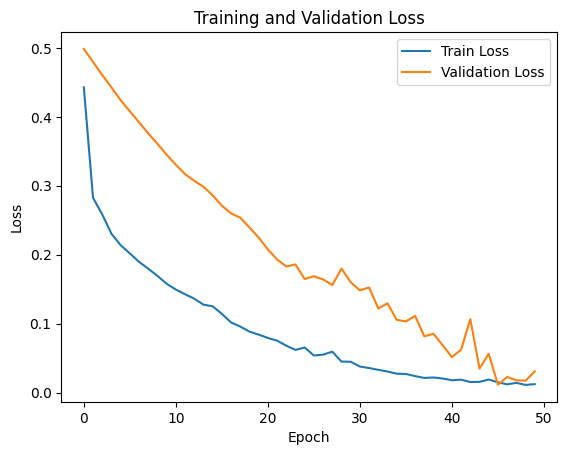

In [25]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [16]:
# ทดสอบโมเดลกับ Test set
y_pred_scaled = model.predict(X_test_scaled)
y_pred_scaled[:5]

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step


array([[[0.49188846, 0.7930829 ],
        [0.52261275, 0.90234524],
        [0.46789122, 0.9276005 ],
        [0.38431782, 0.9120745 ],
        [0.39609057, 0.93375343]],

       [[0.48082143, 0.71887255],
        [0.5148188 , 0.90947574],
        [0.430602  , 0.9222602 ],
        [0.4244029 , 0.9394814 ],
        [0.3348301 , 0.91248447]],

       [[0.47044122, 0.75302666],
        [0.47089618, 0.9126543 ],
        [0.46580517, 0.95227575],
        [0.35987037, 0.91903484],
        [0.2793005 , 0.8662819 ]],

       [[0.4355219 , 0.7402351 ],
        [0.5126223 , 0.93634254],
        [0.40467304, 0.92906123],
        [0.30626732, 0.8716922 ],
        [0.38013238, 0.90883315]],

       [[0.49161035, 0.76376754],
        [0.45632124, 0.90961677],
        [0.3526637 , 0.87907714],
        [0.40818954, 0.9130257 ],
        [0.409015  , 0.95493007]]], dtype=float32)

In [17]:
# แปลงค่ากลับเป็นสเกลเดิม
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, y_pred_scaled.shape[-1])).reshape(y_pred_scaled.shape) #Nomalization ไม่ต้องแปลงกลับ .reshape(-1, y_train.shape[-1])).reshape(y_train.shape)
y_test = scaler_y.inverse_transform(y_test_scaled.reshape(-1, y_test_scaled.shape[-1])).reshape(y_test_scaled.shape)
y_pred[:5] ,y_test[:5]

(array([[[49.76343 , 36.803726],
         [50.21388 , 39.4016  ],
         [49.411606, 40.00208 ],
         [48.18634 , 39.632927],
         [48.35894 , 40.148373]],
 
        [[49.60118 , 35.039265],
         [50.099613, 39.571136],
         [48.86491 , 39.875107],
         [48.774025, 40.284565],
         [47.460804, 39.642673]],
 
        [[49.448994, 35.85133 ],
         [49.455666, 39.64671 ],
         [49.381027, 40.588768],
         [47.827915, 39.798416],
         [46.646683, 38.54414 ]],
 
        [[48.937042, 35.54719 ],
         [50.06741 , 40.209934],
         [48.484768, 40.03681 ],
         [47.042046, 38.672775],
         [48.124977, 39.55586 ]],
 
        [[49.759357, 36.106712],
         [49.24198 , 39.57449 ],
         [47.72226 , 38.848366],
         [48.53632 , 39.65554 ],
         [48.548428, 40.65188 ]]], dtype=float32),
 array([[[49.48110559, 38.48356444],
         [49.11407837, 39.74669395],
         [48.25640186, 39.54992239],
         [49.62255139, 39.96979992